In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context='paper', color_codes=False)

from plotGraphs import *
from MLpipelines.plotResults import *
from imagen_dataloader import *
# from niwidgets import NiftiWidget

In [3]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"

In [4]:
# path to questionaires files
qs = dict(
        AUDIT_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU2-IMAGEN_DIGEST.csv",
        AUDIT_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv",
        ESPAD_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU2-IMAGEN_DIGEST.csv",
        ESPAD_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv",
          
        AUDIT_GM       = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM.csv",
        AUDIT_GM_FINE  = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM_FINE.csv",
        ESPAD_GM       = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM.csv",
        ESPAD_GM_FINE  = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM_FINE.csv",
        
        PHENOTYPE = DATA_DIR + "combinations/drinking_phenotype/Seo_drinking_phenotype_fu2.csv",
        )

### Data

In [5]:
df_demo = pd.read_csv(join(DATA_DIR, "FU3/participants/IMAGEN_demographics.csv"), dtype={"PSC2":int})
df_demo = df_demo.rename(columns={"PSC2" : "ID", "recruitment centre":"site"})
df_demo2 = pd.read_csv(join(DATA_DIR, "IMAGEN_stats_from_db.csv"), sep=";", dtype={"code_in_study":int})
df_demo2 = df_demo2.rename(columns={"code_in_study" : "ID"})[["ID", "gender", "handedness"]]
df_demo = pd.merge(df_demo, df_demo2, on='ID', how="inner")

test_ids = df_demo.loc[df_demo["site"]=="NOTTINGHAM", "ID"]

print("Total subjects in demographics table =", len(df_demo))
print("Total subjects set aside as test set =", len(test_ids))
del df_demo2

Total subjects in demographics table = 2315
Total subjects set aside as test set = 375


In [6]:
dataset = Imagen()
# dataset.df.info()

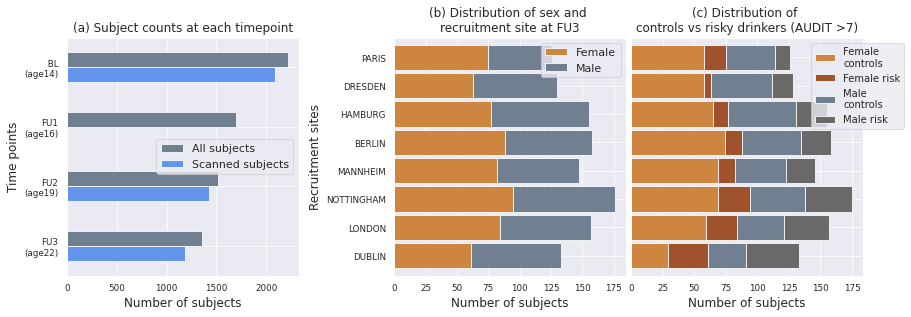

In [61]:
from matplotlib.colors import ListedColormap

fontsize = 12

df = pd.concat([dataset.df, dataset.df_holdout])

f,axes = plt.subplots(1,3, figsize=(14,4.5))

df_temp = df.filter(regex=("(path_T1w)")).notnull().sum().unstack()

df_temp = df_temp.join(pd.Series({"FU3":1359, "FU2":1514, "FU1":1699, "BL":2213}, name="All subjects"),
              how='right')
df_temp = df_temp.rename(columns={"path_T1w":"Scanned subjects"})#, "path_FAsk_DTI":"with DTI data"})
df_temp.index = df_temp.index.map({
                                    "FU3":"FU3\n(age22)",
                                    "FU2":"FU2\n(age19)",
                                    "FU1":"FU1\n(age16)",
                                    "BL" :" BL\n(age14)",
                                })
axis = axes[0]
df_temp.sort_index(ascending=False).plot.barh(
    ax=axis,
    color = ['cornflowerblue', 'slategray'])
axis.set_title("(a) Subject counts at each timepoint", fontsize=fontsize)
axis.set_xlabel('Number of subjects', fontsize=fontsize)
axis.set_ylabel('Time points', fontsize=fontsize)
handles, labels = axis.get_legend_handles_labels()
axis.legend(reversed(handles), reversed(labels), fontsize=fontsize-1, loc='center right')

#################################################################################
valid_subs = df["FU3"]["path_T1w"].dropna().index

##calculate df_audit first for the sort order 
df_audit = pd.read_csv(qs['AUDIT_FU3'], usecols=["audit_abuse_flag", "User code"], dtype={"User code":str})
df_audit["User code"] = df_audit["User code"].apply(lambda x: int(x.replace("-C", "")))
df_audit = df_audit.rename(columns={"User code" : "ID"})
df_audit = df_audit.merge(df_demo[["ID", "sex", "site"]], on="ID")
df_audit = df_audit[df_audit.ID.isin(valid_subs)] 
df_audit = df_audit[["sex", "audit_abuse_flag", "site"]].value_counts().unstack().T
# sort by ratio of alcohol_risk_females / alcohol_risk_males
sort_order = (df_audit[('M', 1)]/df_audit[('M', 0)]).sort_values(ascending=False).index
# select the colors for the area
colors = ['peru', 'sienna',  'slategrey', 'dimgrey'] #'peachpuff', 'lightskyblue',
labels = ['Female\ncontrols', 'Female risk', 'Male\ncontrols', 'Male risk']


df_temp = df["FU3"].loc[valid_subs, ["sex", "site"]].value_counts().unstack().T
# sort by total subjects
df_temp = df_temp.loc[sort_order]

df_temp = df_temp.rename(columns={"F":"Female", "M":"Male"})
df_temp.plot.barh(
    stacked=True, ax=axes[1], width=0.9, 
    color=[colors[0], colors[2]]
)
axes[1].set_title("(b) Distribution of sex and \nrecruitment site at FU3", fontsize=fontsize)
axes[1].set_ylabel('Recruitment sites', fontsize=fontsize)
axes[1].set_xlabel('Number of subjects', fontsize=fontsize)
axes[1].legend(loc="upper right", fontsize=fontsize-1)

# display(df_temp)
axis = axes[2]

df_audit = df_audit.loc[sort_order]
# display(df_audit)
df_audit.plot.barh(
    stacked=True, ax=axis, width=0.9, 
    color=colors)
# x_vals = np.zeros(shape=len(df_audit))
# y_vals = np.arange(len(df_audit.index), dtype=float)
# y_vals[-1] += 0.45 
# y_vals[0] = y_vals[0] - 0.45

# for i, c in enumerate(df_audit):
#     x_vals_new = df_audit[c]
#     axis.fill_betweenx(y=y_vals, x1=x_vals, x2=x_vals + x_vals_new, 
#                        color=colors[i], label=labels[i])
#     x_vals = x_vals + x_vals_new

# axis.set_xlim(0)
axis.set_yticklabels([])
axis.set_ylabel('')
axis.set_xlabel('Number of subjects', fontsize=fontsize)
axis.legend(labels=labels, loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=fontsize-2)
axis.set_title("(c) Distribution of \ncontrols vs risky drinkers (AUDIT >7)", fontsize=fontsize)

plt.tight_layout()
pos = axis.get_position()
pos_pt = pos.get_points()
move_by = pos_pt[0][0] - axes[1].get_position().get_points()[1][0]
pos_pt[:,0] -= move_by - 0.005
pos.set_points(pos_pt)
axis.set_position(pos)

f.savefig("figures/imagen_stats.pdf", format='pdf', bbox_inches='tight', pad_inches=0.05)

In [8]:
len(valid_subs)

1182

### Method: confound control

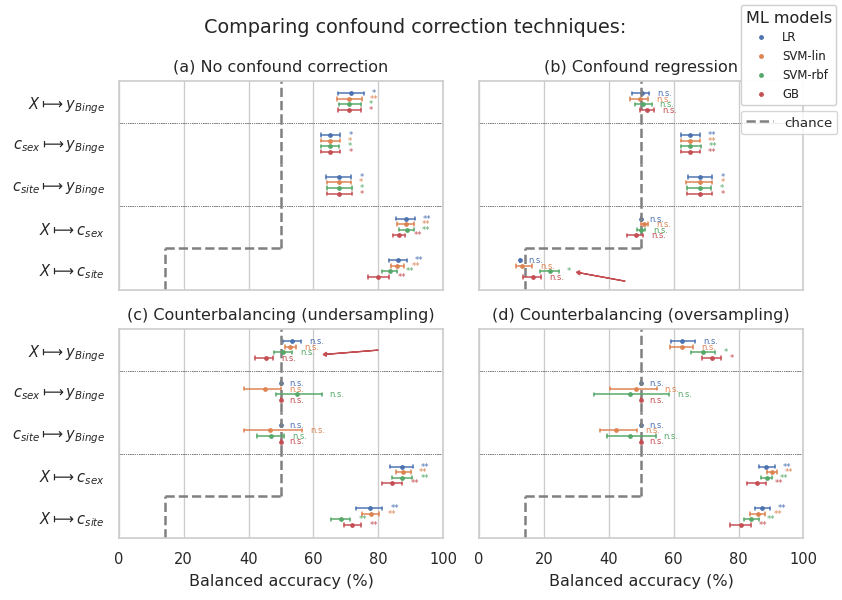

In [73]:
df = pd.read_csv(sorted(glob(f"MLpipelines/results/conf_ctrl/*/run.csv"))[-1])  #audit-combos*audit-c*22

x="test_score"
conf_ctrl=["baseline", "cr", "under-cb", "over-cb"]
conf_ctrl_rename={"baseline":"(a) No confound correction", "cr":"(b) Confound regression", 
                  "under-cb":"(c) Counterbalancing (undersampling)", "over-cb":"(d) Counterbalancing (oversampling)"}
input_type='' #'sMRI (22yrs)'
no_confs=False
sorty_by=None
join=False
    
input_types_cnt = 0
df = df.assign(i_type=input_type)

# drop confound-related predictions if requested
if "i_is_conf" in df.columns and no_confs: 
    df = df[~(df.i_is_conf) & ~(df.o_is_conf)]

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
#     plt.show()
# if conf_ctrl is not configured then automatically determine it
if not conf_ctrl: 
    conf_ctrl = df["technique"].unique()
else:
    df = df[df["technique"].isin(conf_ctrl)]

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1)      

# setup the figure properties
sns.set(style='whitegrid', context='paper')
fig, axes = plt.subplots(2, len(conf_ctrl)//2, 
                         sharex=True, sharey=True, 
                         dpi=120, figsize=(7,5))
axes = axes.ravel()
plt.xlim([0,100])    

y="io"     
y_order = get_y_order(df, y, sorty_by).tolist()
#hacks
df[x] = df[x]*100
y_order = [y_order[2]] + y_order[3:] + y_order[0:2]
df['o'] = df.apply(lambda row: row.o if row.o_is_conf else '', axis=1)

hue_order = [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in df["model"].unique()]

for j, (t, ax) in enumerate(zip(conf_ctrl, axes)): 
    dfi = df.query(f"technique == '{t}'")
    # plotting details
    palette = sns.color_palette()
    ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
    # todo bugfix ci is sensible only if each trial score is statistically independant
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax,
                       ci=ci, errwidth=errwidth, capsize=capsize,
                       dodge=dodge, scale=scale, palette=palette)
#     if j!=len(df["technique"].unique())-1: 
    ax.legend_.remove()
    ax.set_title("{}".format(conf_ctrl_rename[t]))
    ax.set_xlabel("")
    ax.set_ylabel("")
    if j>=(len(conf_ctrl)//2): ax.set_xlabel("Balanced accuracy (%)")

    # Add significance stars if permutation scores are available
    if f"permuted_{x}" in dfi.columns:

        # collect p_values as a dict of form {mean_accuracy: p_value}
        p_dict = {g[x].mean(): g["p_value"].iloc[0] 
                  for i, g in dfi.groupby(["io", "model"])}
        # filter out the error bars from all lines 
        # and store the position of their right edges to print the p_values at 
        err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
                        for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
        # also collect the position of the mean 'accuracy' points
        points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

        for i, pos in enumerate(err_bars_pos):

            p_pos = points_pos[i]
            # check that the y position of both the point and error bar are the same-
            assert p_pos[1] == pos[1], f"y position of mean pt ({p_pos}) and error bar ({pos}) don't match"
            # choose the error bar with the same mean accuracy point
            p =  p_dict[p_pos[0]] 
            ast = return_asterisks(p)

            ax.annotate(ast, np.array(pos) + (2.5, 0.05), 
                        color=palette[i//len(df[y].unique())], fontsize=5)
    
    if t=='cr':
        ax.arrow(45, 4.3, -14, -0.2, head_width=0.1, head_length=1, fc='r', ec='r')
    elif t=='under-cb':
        ax.arrow(80, 0.01, -16, 0.1, head_width=0.1, head_length=1, fc='r', ec='r')
        
    # draw the chance line in the legend
    chance= [50, 50, 50, 50, 100/7][::-1]
    for z, ch in enumerate(chance): 
        ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), label="chance", c='gray', ls='--', lw=1.5)
    ax.axhline(y=3.5, xmin=1/7,  xmax=0.5, c='gray', ls='--', lw=1.5) #hack
            
    for v in [0.5, 2.5]*len(dfi[y].unique()): 
        ax.axhline(y=v, c='gray', ls=':', lw=0.5)
    
# add legend: add models info and chance label
# handles, legends = ax.get_legend_handles_labels()
# #only choose the first 'chance' legend
# handles = [handles[0]] + handles[-len(hue_order):]
# legends = [legends[0]] + legends[-len(hue_order):]
# fig.legend(handles, legends, loc="upper right", 
#            fancybox=True, frameon=True) 

handles, legends = ax.get_legend_handles_labels()
leg1 = fig.legend(handles[len(chance):], legends[len(chance):], loc="upper right", title="ML models", fontsize=7) #
# only choose the first 'chance' legend
import matplotlib.lines as mlines
leg2 = fig.legend([handles[0]], [legends[0]], loc=(0.88, 0.775), fontsize=8)
fig.add_artist(leg1)
plt.suptitle("Comparing confound correction techniques:")
plt.tight_layout()
plt.savefig("figures/results_cc.pdf", bbox_inches='tight', pad_inches=0.05)

### Results:

#### Exploratory results

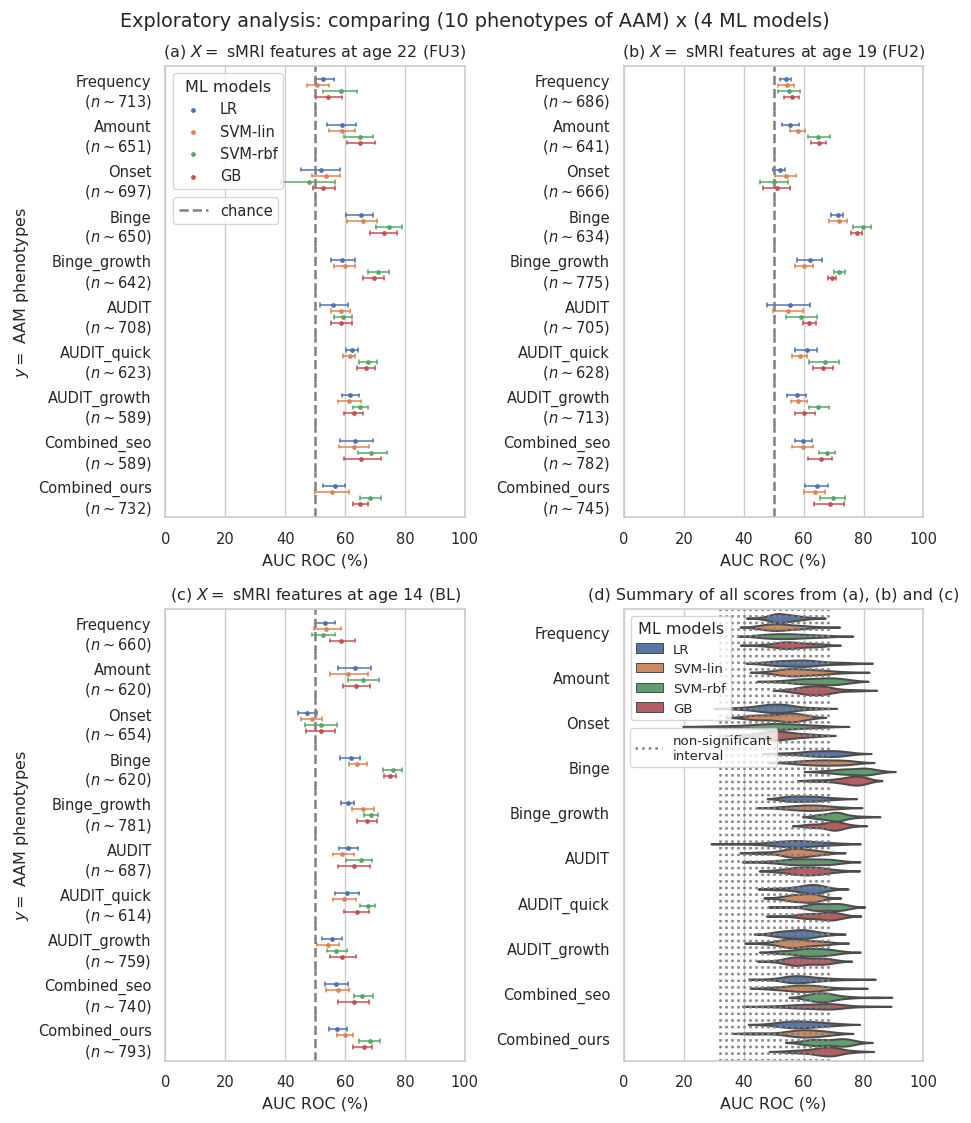

In [75]:
r_path = "newlbls" #"across_sites/lbls"

df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-fu3*/*/run.csv"))]),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-fu2*/*/run.csv"))]),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-bl*/*/run.csv"))]),
]
x = "roc_auc"#'roc_auc'
conf_ctrl = 'cb'
sorty_by = None #'n_samples'
join = False
n_ios = 10
xlim = [0, 100]
# setup the figure properties
sns.set(style='whitegrid', context='paper')

fig, axes = plt.subplots(2, 2, 
                         sharex=False, sharey=(x=="test_score"),  dpi=120,
                         figsize=(4*2, 1.9*(1+0.4*(n_ios))))
summary_ax = axes[1][1]
remaining_axs = [ax for ax in axes.ravel() if (ax != summary_ax)]

df = pd.DataFrame()

# HACK : set the input_sMRI_type as a 'technique' to make the rest of the function work
for t, df_full in df_fulls:
    dfi = pd.concat(df_full)
    # drop confound-related columns
    dfi = dfi[~(dfi.i_is_conf) & ~(dfi.o_is_conf)]
    dfi = dfi[dfi["technique"]==conf_ctrl]
    # calculate p_values if permutation tests were run
    if f"permuted_{x}" in dfi.columns:
        dfi = calc_p_values(dfi, x)
    dfi["technique"] = t
    df = pd.concat([df, dfi])

# fixes
xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
df.loc[df["o"]=="onset<15", "o"]="Onset"
df[x] = df[x]*100

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)
    
####################################################################
    
y="o"     
y_order = ['Frequency','Amount',  'Onset',  'Binge', 'Binge_growth', 
           'AUDIT', 'AUDIT_quick', 'AUDIT_growth', 'Combined_seo','Combined_ours' ]#get_y_order(df, y=y, sorty_by=sorty_by)

for j, ((t, dfi), ax) in enumerate(zip(df.groupby("technique", sort=False), remaining_axs)):   
    # plotting details
    palette = sns.color_palette()
    ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
    hue_order = ["LR", "SVM-lin", "SVM-rbf", "GB"]
    # todo bugfix ci is sensible only if each trial score is statistically independant
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax,
                       ci=ci, errwidth=errwidth, capsize=capsize,
                       dodge=dodge, scale=scale, palette=palette)
    
    # since sample_size are different for different io (i.e. they are from different data subsets)
    # add sample_size info in y_label
    if x!="test_score":
        labels = ax.get_yticklabels()
        for label in labels:
            n_samples = df.loc[(df["o"]==label.get_text())&(df["technique"]==t), "n_samples"].iloc[0]
            new_label = f"{label.get_text()}\n $(n\sim{n_samples})$"
            label.set_text(new_label)
        ax.set_yticklabels(labels)

    ax.set_title(t)
    ax.set_xlim(xlim)
    ax.set_ylabel("")
    if j in [0,2]: ax.set_ylabel(r"$y=$ AAM phenotypes")
    ax.set_xlabel(xlabel)
        
    # Add significance stars if permutation scores are available
    if f"permuted_{x}" in dfi.columns:

        n_y_rows = len(dfi["o"].unique())
        # collect p_values as a dict of form {mean_accuracy: p_value}
        mean_acc, p_vals = zip(*((g[x].mean(), g["p_value"].iloc[0])
                  for i, g in dfi.groupby(["io", "model"])))
        # perform FDR correction
#         print("\nbefore correction:\n", np.array(p_vals))
#         _,p_vals = fdrcorrection(p_vals)
#         print("after correction:\n", p_vals)
        p_dict = dict(zip(mean_acc, p_vals))
        # filter out the error bars from all lines 
        # and store the position of their right edges to print the p_values at 
        err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
                        for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
        # also collect the position of the mean 'accuracy' points
        points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

        for i, pos in enumerate(err_bars_pos):
            p_pos = points_pos[i]
            # check that the y position of both the point and error bar are the same
            assert p_pos[1] == pos[1]
            # choose the error bar with the same mean accuracy point
            p =  p_dict[p_pos[0]] 
            ast = return_asterisks(p)
            ax.annotate(ast, np.array(pos)+(0.02, 0.06), 
                        color=palette[i//n_y_rows], fontsize=5)

    # draw the chance line in the legend
    chance = (len(dfi[y].unique()))*[50] #todo
    for z, ch in enumerate(chance): 
        ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
                   label='chance', c='gray', ls='--', lw=1.5)

    if j==0:#len(df.groupby("technique"))-1:
        # add legend: add models info and chance label to last plot
        handles, legends = ax.get_legend_handles_labels()
        leg1 = ax.legend(handles[len(chance):], legends[len(chance):], loc="upper left", title="ML models")
        # only choose the first 'chance' legend
        leg2 = ax.legend([handles[0]], [legends[0]], fancybox=True, frameon=True, loc=(0.025, 0.65))
        ax.add_artist(leg1)
        
    else:
        ax.legend_.remove()
        
#########################
# plt.rcParams["figure.figsize"]=(16, 14)
ax = sns.violinplot(data=df, ax=summary_ax,
                     y=y, x=x, order=y_order,
                    hue="model", hue_order=hue_order,
                   inner=None)

ax.set_title("(d) Summary of all scores from (a), (b) and (c)")
ax.set_xlim(xlim)
ax.set_ylabel("")
ax.set_xlabel(xlabel)
leg1 = ax.legend(title="ML models", loc="upper left", fontsize=8)

color='gray'
# ax.axvline(x=50, c=color, lw=, alpha=0.3, label='non-significant\ninterval')
insigificance_interval = (32,70) if x=='roc_auc' else (35,65)
for xi in range(*insigificance_interval,2): 
#     ax.axvline(x=50, c=color, lw=lw, alpha=0.1)
# ax.axvline(x=50, c=color, label='chance', ls='--', lw=1.5, alpha=1)
    ax.axvline(x=xi, c=color, ls=':', lw=1.5, alpha=1, label='non-significant\ninterval')
# ax.axvline(x=40, c=color, ls=':', lw=1.5, alpha=1)
handles, legends = ax.get_legend_handles_labels()
leg2 = ax.legend([handles[0]], [legends[0]], loc=(0.02, 0.65), fontsize=8)
ax.add_artist(leg1)
    
# if "across_sites" in r_path:
#     plt.suptitle("Exploratory analysis with leave-one-site-out CV (7-folds)")
#     plt.tight_layout()
#     plt.savefig("figures/results_explore_sites{}.pdf".format("_auc" if x=='roc_auc' else ''))
# else:
plt.suptitle("Exploratory analysis: comparing (10 phenotypes of AAM) x (4 ML models)")
plt.tight_layout()
plt.savefig("figures/results_explore{}.pdf".format("_auc" if x=='roc_auc' else ''), bbox_inches='tight', pad_inches=0.05)

#### Independent inference

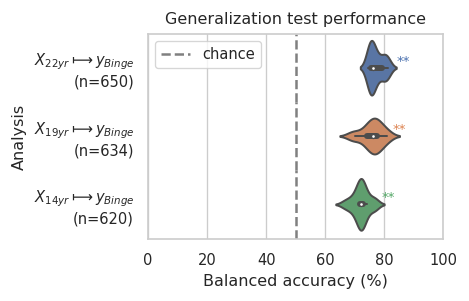

In [114]:
df = pd.read_csv("MLpipelines/holdout_results.csv")  

x='holdout_score'
no_confs=True
sorty_by=x
join=False

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 
  
# hack: set all models as one
# df["model"]= "model"

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
    
ios = df["io"].unique() 

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1) 
df[x] = df[x]*100  

# setup the figure properties
sns.set(style='whitegrid', context='paper')
fig, ax = plt.subplots(dpi=120, figsize=(4, 1+0.4*(len(ios)+input_types_cnt)))
    
plt.xlim([0,100])    
hue=None #"model" #hack
y="io"     
all_models = df["model"].unique()
# if sample_size are different for different io (i.e. they are from different data subsets)
# then print this info in y_label
df = combine_io_sample_size(df)
y="io_n" 
y_order = get_y_order(df, y, sorty_by)[::-1]
# plotting details
palette = sns.color_palette()
ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
hue_order= [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in all_models]

ax = sns.violinplot(y=y, x=x, order=y_order, hue=hue, hue_order=hue_order,
              data=df, ax=ax, dodge=dodge, palette=palette)

# draw the chance line in the legend
chance = (len(df[y].unique()))*[50] #todo
for z, ch in enumerate(chance): 
    ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
                label="chance", c='gray', ls='--', lw=1.5)

# perform FDR correction
from statsmodels.stats.multitest import multipletests
p_vals = [df.loc[df[y]==yi, "p_value"].unique()[0] for yi in y_order]
# print("\nbefore correction:\n", p_vals)
_,p_vals,_,_ = multipletests(p_vals, method="fdr_bh")
# print("after correction:\n", p_vals)
# add significance stars
for k, yi in enumerate(y_order):
    ast = return_asterisks(p_vals[k])
    ax.annotate(ast, 
                xy=(df.loc[df[y]==yi, x].mean()+7, k - 0.05), 
                color=palette[k], fontsize=8)

        
handles, legends = ax.get_legend_handles_labels()
ax.legend([handles[0]], [legends[0]], fancybox=True, frameon=True, loc="upper left")

plt.title(r"Generalization test performance")
plt.xlabel("Balanced accuracy (%)")
plt.ylabel("Analysis")
plt.tight_layout()
# plt.show()
plt.savefig("figures/results_infer.pdf", bbox_inches='tight', pad_inches=0.05)

In [115]:
x = "holdout_score"
for g, dfi in df.groupby(["i_type"]):
    print(g, dfi[x].mean())

14yr 72.09161551889183
19yr 75.89954389323722
22yr 77.21577791542316


/ritter/roshan/workspace/imagen_ml/MLpipelines/plotResults.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(item) for item in range(0,120, 120//len(ax.get_xticklabels()))])


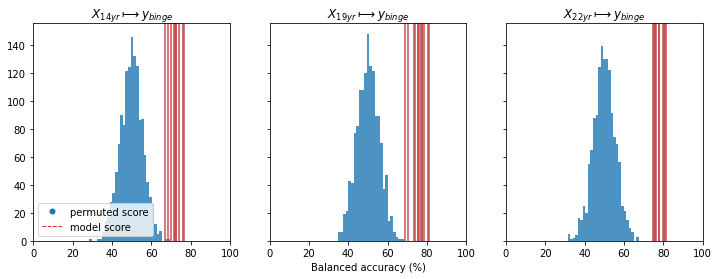

In [84]:
df = pd.read_csv("MLpipelines/holdout_results.csv")  

x='holdout_score'
no_confs=True
sorty_by=x
join=False

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 
  
# hack: set all models as one
df["model"]= "model"

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=True)
    
plt.savefig("figures/results_infer_pvals.pdf", bbox_inches='tight', pad_inches=0.05)

#### Other: Cross-site generalization

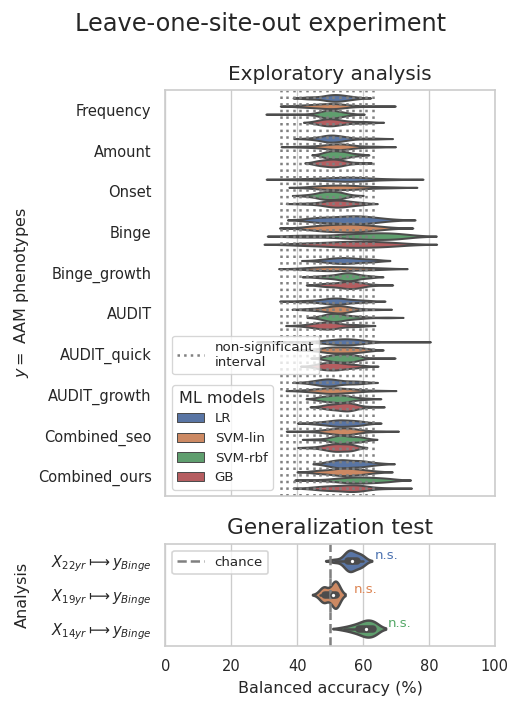

In [112]:
r_path = "lbls"
HOLDOUT_RESULTS = "MLpipelines/holdout_results_sites.csv"
OUTPUT = "results_sites"
df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-fu3*/*/run.csv"))]),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-fu2*/*/run.csv"))]),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-bl*/*/run.csv"))]),
]
x = "test_score"#'roc_auc'
conf_ctrl = 'cb'
sorty_by = None #'n_samples'
join = False
n_ios = 10
xlim = [0, 100]
# setup the figure properties
sns.set(style='whitegrid', context='paper')

fig, axes = plt.subplots(2, 1, dpi=120, sharex=True,
                         gridspec_kw={'height_ratios': [4, 1]},
                         figsize=(4.5, (1+0.5*(n_ios))))
explore_ax, infer_ax = axes

df = pd.DataFrame()

ax = axes[0]
# HACK : set the input_sMRI_type as a 'technique' to make the rest of the function work
for t, df_full in df_fulls:
    dfi = pd.concat(df_full)
    # drop confound-related columns
    dfi = dfi[~(dfi.i_is_conf) & ~(dfi.o_is_conf)]
    dfi = dfi[dfi["technique"]==conf_ctrl]
    # calculate p_values if permutation tests were run
    if f"permuted_{x}" in dfi.columns:
        dfi = calc_p_values(dfi, x)
    dfi["technique"] = t
    df = pd.concat([df, dfi])

# hacks
xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
df.loc[df["o"]=="onset<15", "o"]="Onset"
df[x] = df[x]*100

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)
    
y="o"     
y_order = ['Frequency','Amount',  'Onset',  'Binge', 'Binge_growth', 
           'AUDIT', 'AUDIT_quick', 'AUDIT_growth', 'Combined_seo', 'Combined_ours']#get_y_order(df, y=y, sorty_by=sorty_by)

palette = sns.color_palette()
ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
hue_order = ["LR", "SVM-lin", "SVM-rbf", "GB"]

# plt.rcParams["figure.figsize"]=(16, 14)
ax = sns.violinplot(data=df, ax=explore_ax,
                     y=y, x=x, order=y_order,
                    hue="model", hue_order=hue_order,
                   inner=None)

ax.set_title("Exploratory analysis", fontsize=12)
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"$y=$ AAM phenotypes")
leg1 = ax.legend(title="ML models", loc="lower left", fontsize=8)

color='gray'
insigificance_interval = (32,70) if x=='roc_auc' else (35,65)
for xi in range(*insigificance_interval,2): 
    ax.axvline(x=xi, c=color, ls=':', lw=1.5, alpha=1, label='non-significant\ninterval')
    
handles, legends = ax.get_legend_handles_labels()
leg2 = ax.legend([handles[0]], [legends[0]], loc=(0.02, 0.3), fontsize=8)
ax.add_artist(leg1)

#######################################################################################

df = pd.read_csv(HOLDOUT_RESULTS)  
x='holdout_score'
no_confs=True
sorty_by=None
join=False

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 
  
# hack: set all models as one
df["model"]= "model"

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
    
ios = df["io"].unique() 

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1) 
df[x] = df[x]*100  

# setup the figure properties    
hue=None #"model" hack
y="io"     
all_models = df["model"].unique()
# if sample_size are different for different io (i.e. they are from different data subsets)
# then print this info in y_label
# df = combine_io_sample_size(df)
# y="io_n" 
y_order = get_y_order(df, y, sorty_by)[::-1]
hue_order= [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in all_models]

ax = sns.violinplot(y=y, x=x, order=y_order, hue=hue, hue_order=hue_order,
              data=df, ax=infer_ax, dodge=dodge, palette=palette)

# draw the chance line in the legend
chance = (len(df[y].unique()))*[50] #todo
for z, ch in enumerate(chance): 
    ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
                label="chance", c='gray', ls='--', lw=1.5)

# perform FDR correction
from statsmodels.stats.multitest import multipletests
p_vals = [df.loc[df[y]==yi, "p_value"].unique()[0] for yi in y_order]
# print("\nbefore correction:\n", p_vals)
_,p_vals,_,_ = multipletests(p_vals, method="bonferroni")
# print("after correction:\n", p_vals)
# add significance stars
for k, yi in enumerate(y_order):
    ast = return_asterisks(p_vals[k])
    ax.annotate(ast, 
                xy=(df.loc[df[y]==yi, x].mean()+7, k - 0.05), 
                color=palette[k], fontsize=8)

        
handles, legends = ax.get_legend_handles_labels()
ax.legend([handles[0]], [legends[0]], fancybox=True, frameon=True, loc="upper left", fontsize=8)
ax.set_title("Generalization test", fontsize=13)
ax.set_ylabel("Analysis", labelpad=13)
plt.suptitle("Leave-one-site-out experiment")
plt.xlabel(xlabel)
plt.tight_layout()
plt.savefig("figures/{}{}.pdf".format(OUTPUT, "_auc" if x=='roc_auc' else ''), bbox_inches='tight', pad_inches=0.05)

#### Other: input imaging features

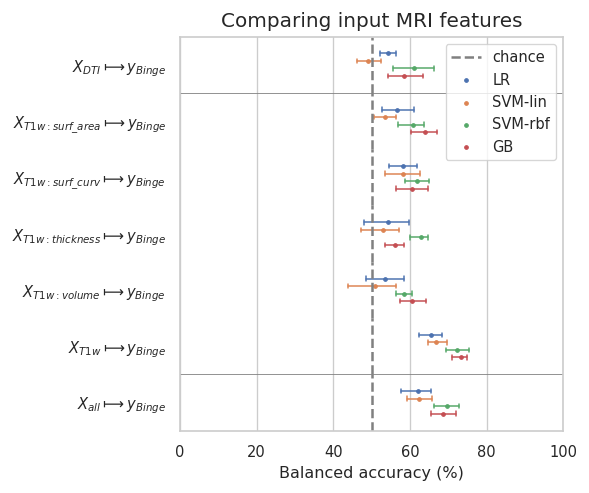

In [113]:
modalities = {
              "":"all", 
              "dti":"DTI", 
              "t1w":"T1w", 
              "area":"T1w:surf_area", "volume":"T1w:volume", "thickness":"T1w:thickness", "curv":"T1w:surf_curv"}
dfs=[]
input_types=[]

for fil, name in modalities.items():
    f = glob(f"MLpipelines/results/imaging_modalities/newlbls{fil}-*19a*/*/run.csv")
#     print(f)
    df = pd.read_csv(f[0])
    # determine the input type for folder name
    input_type = "{}".format(modalities[fil])
    dfs.extend([df])
    input_types.extend([input_type])

####
df_full=dfs
x="test_score"
conf_ctrl=['cb']
input_type=input_types
no_confs=True
sorty_by=None
join=False
    
input_types_cnt = 0
if isinstance(df_full, (list, tuple)):
    if isinstance(input_type, (list, tuple)) and len(input_type)==len(df_full):
        df_full = [dfi.assign(i_type=i_type) for dfi, i_type in zip(df_full, input_type)]
        input_types_cnt = len(input_type)
    else:
        df_full = [dfi.assign(i_type=input_type) for dfi in df_full]
    df = pd.concat(df_full)
    is_multi = True
else:
    df = df_full.copy()
    df = df.assign(i_type=input_type)
    is_multi = False
# drop confound-related predictions if requested
if "i_is_conf" in df.columns and no_confs: 
    df = df[~(df.i_is_conf) & ~(df.o_is_conf)]

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x)

# if conf_ctrl is not configured then automatically determine it
if not conf_ctrl: 
    conf_ctrl = df["technique"].unique()
else:
    df = df[df["technique"].isin(conf_ctrl)]

ios = df["io"].unique() 
# fixes
xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
df.loc[:,"o"]== ""
df[x] = df[x]*100

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1)     
#   models_rename = {"LogisticRegression":"LR", "LinearSVC":"SVM-lin", "SVC":"SVM-rbf", "GradientBoostingClassifier":"GB"} # todo remove this backward compatibility code
#     df = df.assign(model=lambda d: d.model.map(models_rename))    

# setup the figure properties
sns.set(style='whitegrid', context='paper')
fig, axes = plt.subplots(1, len(conf_ctrl), 
                         sharex=True, sharey=True, 
                         dpi=120, figsize=(5*len(conf_ctrl), 1+0.4*(len(ios)+input_types_cnt)))
if not isinstance(axes, np.ndarray): axes = [axes]
plt.gca().set_xlim([0,100])    

y="io"     
y_order = get_y_order(df, y, sorty_by)

for ((t, dfi), ax) in zip(df.groupby("technique"), axes):   

    all_models = dfi["model"].unique()
    # plotting details
    palette = sns.color_palette()
    ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
    hue_order= [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in all_models]
    # todo bugfix ci is sensible only if each trial score is statistically independant
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax,
                       ci=ci, errwidth=errwidth, capsize=capsize,
                       dodge=dodge, scale=scale, palette=palette)
    ax.legend_.remove()
    ax.set_ylabel("")

    # Add significance stars if permutation scores are available
    if f"permuted_{x}" in dfi.columns:

        # collect p_values as a dict of form {mean_accuracy: p_value}
        p_dict = {g[x].mean(): g["p_value"].iloc[0] 
                  for i, g in dfi.groupby(["io", "model"])}
        # filter out the error bars from all lines 
        # and store the position of their right edges to print the p_values at 
        err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
                        for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
        # also collect the position of the mean 'accuracy' points
        points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

        for i, pos in enumerate(err_bars_pos):

            p_pos = points_pos[i]
            # check that the y position of both the point and error bar are the same
            assert p_pos[1] == pos[1], f"y position of mean pt ({p_pos}) and error bar ({pos}) don't match"
            # choose the error bar with the same mean accuracy point
            p =  p_dict[p_pos[0]] 
            ast = return_asterisks(p)

            ax.annotate(ast, np.array(pos) + (0.02, 0.06), 
                        color=palette[i//len(df[y].unique())], fontsize=5)

    # draw the chance line in the legend
    chance = (len(dfi[y].unique()))*[50] #todo
    for z, ch in enumerate(chance): 
        ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
                    label="chance", c='gray', ls='--', lw=1.5)

# add legend: add models info and chance label
handles, legends = ax.get_legend_handles_labels()
#only choose the first 'chance' legend
handles = [handles[0]] + handles[len(chance):]
legends = [legends[0]] + legends[len(chance):]
plt.legend(handles, legends, loc="upper right", 
           fancybox=True, frameon=True) 

plt.axhline(0.5, color='gray', lw=0.5)
plt.axhline(5.5, color='gray', lw=0.5)
plt.title("Comparing input MRI features", fontsize=12)
plt.xlabel(xlabel)
plt.tight_layout()
plt.savefig("figures/results_modality.pdf")

In [722]:
import h5py as h5
f = h5.File('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-19a-binge-n620.h5' ,'r')

df = pd.DataFrame(f[f.attrs['labels'][0]], index=list(f['i']), columns=f.attrs['labels'], dtype=int)
# df.info()

df["Binge"].value_counts()

1    334
0    286
Name: Binge, dtype: int64

In [720]:
from imagen_dataloader import qs
espad_BL = pd.read_csv(qs["ESPAD_BL"], sep=",", dtype={"User code":str, "Valid":str}, usecols=["User code", "19a"])
espad_BL["User code"] = espad_BL["User code"].apply(lambda x: int(x.replace("-C", "")))
espad_BL = espad_BL.rename(columns={"User code" : "ID"}).set_index("ID", drop=True)
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])
# remapvalues_17x = {0:'0',1:'1',2:'2',3:'3-5',4:'6-9',5:'> 10', -1:"missing"}

df["Binge_age14"] = espad_BL["19a"]

df.value_counts().unstack()

Binge_age14,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Binge,,,,,,,
0,178.0,21.0,4.0,3.0,1.0,NaN,1.0
1,154.0,67.0,18.0,12.0,10.0,4.0,NaN


In [1]:
(154.0 	+ 67.0 +	18.0 +	12.0 +	10.0 +	4.0)

265.0

<AxesSubplot:xlabel='Binge', ylabel='Binge_age14'>

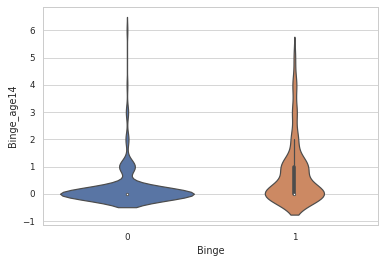

In [714]:
sns.violinplot(data=df, y="Binge_age14", x="Binge", split=False)

In [685]:
df.Binge.value_counts()

1.0    368
0.0    282
Name: Binge, dtype: int64